# Set up

## Package Loading

In [32]:
import numpy as np 
import pandas as pd 
!pip install fasttext
import fasttext
import bz2
import csv
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.model_selection import train_test_split
import time
import seaborn as sns
import re
import spacy
from nltk.stem import WordNetLemmatizer
import nltk
#nltk.download('punkt')
#nltk.download('stopwords')
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support


[notice] A new release of pip available: 22.1.2 -> 22.2.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## Set up paths

In [25]:
path_data = '../../../../data/external/Harmful_and_Cyberbullying/data.csv'
path_train = 'train_text.txt'
path_test = 'test_text.txt'
path_valid = 'valid_text.txt'

## Set up functions

In [26]:
def convert_labels(label):
  label = int(label)
  if label == 1:
    return '__label__1'
  else:
    return '__label__0'

#  Train Test split and Data Preparation

In [35]:
df = pd.read_csv(path_data)
df['text'] = df['tweet']
df.drop(columns=['tweet'], inplace = True)
df['label'] = df['label'].apply(convert_labels)

# pre processing 
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')

lemmatizer = WordNetLemmatizer()

df['text'] = df['text'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(x)]))
print(df.head())

train, test = train_test_split(df, test_size=0.2, random_state = 453, stratify=df['label'])
test, valid = train_test_split(test, test_size=0.5 , random_state = 453, stratify= test['label'])

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\timja\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\timja\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


        label                                               text
0  __label__0  In other word # katandandre , your food wa cra...
1  __label__0  Why is # aussietv so white ? # MKR # theblock ...
2  __label__0  @ XochitlSuckkks a classy whore ? Or more red ...
3  __label__0  @ Jason_Gio meh . : P thanks for the head up ,...
4  __label__0  @ RudhoeEnglish This is an ISIS account preten...


# Transformation to txt

In [36]:
train.to_csv(path_train, index=False, sep=' ', header=False, quoting=csv.QUOTE_NONE, quotechar="", escapechar=" ")
valid.to_csv(path_valid, index=False, sep=' ', header=False, quoting=csv.QUOTE_NONE, quotechar="", escapechar=" ")
test_labels = []
test_list = []
for index, row in test.iterrows():
    test_list.append(row['text'])
    test_labels.append(row['label'])

# Modeling

In [38]:
start_time = time.time()

model = fasttext.train_supervised(path_train, label_prefix='__label__', thread=4, epoch = 10)
#model = fasttext.train_supervised(input=path_train, autotuneValidationFile=path_valid, autotuneDuration=600)

# measure time 
end_time = time.time()
measured_time = end_time - start_time
print("--- The training took: %s seconds ---" % (measured_time))

print(model.labels, 'are the labels or targets the model is predicting')

--- The training took: 3.406747579574585 seconds ---
['__label__1', '__label__0'] are the labels or targets the model is predicting


# Prediction

In [34]:
test_list = [w.replace('\n', '') for w in test_list]

start_time = time.time()

# Use the predict function 
pred = model.predict(test_list)

# measure time 
end_time = time.time()
measured_time = end_time - start_time
print("--- The predicting took: %s seconds ---" % (measured_time))

# check the first record outputs
print(pred[0][0], 'is the predicted label')

--- The predicting took: 0.7635650634765625 seconds ---
['__label__0'] is the predicted label


In [33]:
labels = [0 if x.split(' ')[0] == '__label__0' else 1 for x in test_labels]
pred_labels = [0 if x == ['__label__0'] else 1 for x in pred[0]]

# run the accuracy measure. 
print(roc_auc_score(labels, pred_labels))
print(f1_score(labels, pred_labels, average='macro'))
print(precision_recall_fscore_support(labels, pred_labels, average='macro'))
print(accuracy_score(labels, pred_labels))

0.8885759411902563
0.8886606283427618
(0.8887525504151839, 0.8885759411902563, 0.8886606283427618, None)
0.8890144381669806


## Predict oscar data 

In [9]:
path_oscar_en_1gb = path_oscar_1gb_eng = '../../../../data/raw/Oscar_data/en_meta_part_1.jsonl'

In [10]:
df_en = pd.read_json(path_oscar_1gb_eng, lines=True)
df_en

,content,warc_headers,metadata
0,Botany 2013 - Phylogenetic relationships in Br...,"{'content-length': '3090', 'warc-record-id': '...","{'identification': {'label': 'en', 'prob': 0.6..."
1,HOW EXACTLY TO MEET SHEMALES Meeting shemales ...,{'warc-refers-to': '<urn:uuid:0244a561-2fe4-40...,"{'identification': {'label': 'en', 'prob': 0.7..."
2,Message (778) 294-7737Call (778) 294-7737Get d...,"{'content-length': '1498', 'warc-block-digest'...","{'identification': {'label': 'en', 'prob': 0.6..."
3,Aarambh India FX is a premier name in the real...,"{'content-length': '1397', 'warc-type': 'conve...","{'identification': {'label': 'en', 'prob': 0.9..."
4,"First described over 100 years ago, B. megater...",{'warc-block-digest': 'sha1:GOX4ZR3A4AO56LTX2X...,"{'identification': {'label': 'en', 'prob': 0.6..."
...,...,...,...
137116,In order to take full advantage of the feature...,{'warc-target-uri': 'https://www.chevytalk.org...,"{'identification': {'label': 'en', 'prob': 0.9..."
137117,"Cookies are used for measurement, ads and opti...",{'warc-target-uri': 'https://www.cheyenne.org/...,"{'identification': {'label': 'en', 'prob': 0.9..."
137118,Pediatric dentists practice cosmetic dentistry...,"{'content-type': 'text/plain', 'content-length...","{'identification': {'label': 'en', 'prob': 0.9..."
137119,Local and national studies demonstrate the nee...,{'warc-target-uri': 'https://www.chicagosfoodb...,"{'identification': {'label': 'en', 'prob': 0.8..."


In [13]:
df_en.drop(columns="warc_headers", inplace=True)
df_en.drop(columns="metadata", inplace=True)
# pre processing 
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')

lemmatizer = WordNetLemmatizer()

df_en['content'] = df_en['content'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(x)]))
df_en

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\timja\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\timja\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


,content
0,Botany 2013 - Phylogenetic relationship in Bra...
1,HOW EXACTLY TO MEET SHEMALES Meeting shemales ...
2,Message ( 778 ) 294-7737Call ( 778 ) 294-7737G...
3,Aarambh India FX is a premier name in the real...
4,"First described over 100 year ago , B. megater..."
...,...
137116,In order to take full advantage of the feature...
137117,"Cookies are used for measurement , ad and opti..."
137118,Pediatric dentist practice cosmetic dentistry ...
137119,Local and national study demonstrate the need ...


In [14]:
# predicting 
test_list = []
for index, row in df_en.iterrows():
    test_list.append(row['content'])
test_list = [w.replace('\n', '') for w in test_list]

start_time = time.time()

# Use the predict function 
pred = model.predict(test_list)

# measure time 
end_time = time.time()
measured_time = end_time - start_time
print("--- The predicting took: %s seconds ---" % (measured_time))


--- The predicting took: 41.66070532798767 seconds ---


In [15]:
prediction = pd.DataFrame(pred[0], columns=['Label'])
prediction

,Label
0,__label__1
1,__label__1
2,__label__0
3,__label__1
4,__label__1
...,...
137116,__label__1
137117,__label__1
137118,__label__1
137119,__label__1


In [16]:
concat = pd.concat([df_en, prediction], axis=1)
concat

,content,Label
0,Botany 2013 - Phylogenetic relationship in Bra...,__label__1
1,HOW EXACTLY TO MEET SHEMALES Meeting shemales ...,__label__1
2,Message ( 778 ) 294-7737Call ( 778 ) 294-7737G...,__label__0
3,Aarambh India FX is a premier name in the real...,__label__1
4,"First described over 100 year ago , B. megater...",__label__1
...,...,...
137116,In order to take full advantage of the feature...,__label__1
137117,"Cookies are used for measurement , ad and opti...",__label__1
137118,Pediatric dentist practice cosmetic dentistry ...,__label__1
137119,Local and national study demonstrate the need ...,__label__1


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


__label__1    0.748186
__label__0    0.251814
Name: Label, dtype: float64


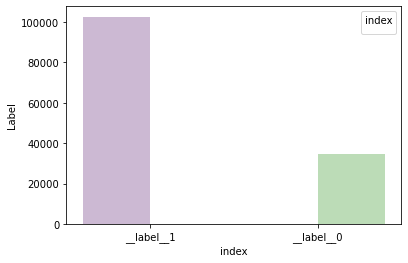

In [17]:
sns.barplot( x='index',y='Label', hue='index', 
            data=pd.DataFrame(concat['Label'].value_counts()).reset_index(), 
            palette="PRGn")
print(concat.Label.value_counts()/len(concat))